## Library Import

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
from pandas.tseries.offsets import Minute,Second
import matplotlib.pyplot as plt
import pandas_profiling

from sklearn.preprocessing import QuantileTransformer,MinMaxScaler,StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,TensorDataset
from statsmodels.tsa.seasonal import seasonal_decompose


plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (14, 9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
%matplotlib inline

## Data Import

In [15]:
green_ = pd.read_csv('green_.csv',index_col=0)
green_scaler = StandardScaler()
seqence_len=100

In [16]:
green_train, green_test = green_.fillna(0).iloc[:int(len(green_)*0.6),:],green_.iloc[int(len(green_)*0.6):,:]  # 6 :4 의 train / test
green_scaler.fit(green_train)
green_x,green_y = create_sequences(green_train,seqence_len,green_scaler,dummies = 6)

In [17]:
train_x,val_x,train_y,val_y = train_test_split(green_x,green_y,
                                                 random_state=219,test_size = 0.2,shuffle=True)  # val 데이터 분리

In [18]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model, self.path)
        self.val_loss_min = val_loss
        
# 데이터 변환 및 주기설정
def create_sequences(data, seq_length,scaler,dummies=None):    
    xs = []
    ys = []
    for i in range(len(data)-seq_length): 
        x = data.iloc[i:(i+seq_length)]  # 처음부터 seq_length 까지를 하나의 묶음으로만듦
        if dummies:  # 카테고리화한 더미데이터가 있으면 해당 컬럼은 결과에서 제외
            y = data.iloc[i+seq_length,:-dummies]
        else:
            y = data.iloc[i+seq_length,:]
        xs.append(scaler.transform(x))  # 입력값만 정규화
        ys.append(y)        
    return torch.from_numpy(np.array(xs)).float().to(device), torch.from_numpy(np.array(ys)).float().to(device)

In [19]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Sequential(
            nn.Linear(in_features=n_hidden, out_features=48),            
        )
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [20]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, 
                verbose = 10, patience = 10,weight_path='best',lr=0.001):    
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset            
            # train loss
            seq = torch.unsqueeze(seq, 0).to(device)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 
                    
                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')                    
                    break
                else:
                    print('\n Save weight')                    
                    torch.save({'epoch':t,
                               'model_state_dict':model.state_dict(),
                               'optimizer_state_dict':optimiser.state_dict(),
                               'loss':loss}
                               ,f'TOMPOP_weight/{weight_path}.pt')

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')
        

            
    return model, train_hist, val_hist

## Model Train

In [27]:
model = LSTM(
    n_features=54,
    n_hidden=64,
    seq_len=seqence_len,
    n_layers=1,    
).to(device)
model, train_hist, val_hist = train_model(
    model,
    train_x,
    train_y,
    val_x,
    val_y,
    num_epochs=10,# epoch 조절
    verbose=1,
    patience=50,
    weight_path = 'result',  # 저장될 모델이름
    lr=0.0001
)

Epoch 0 train loss: 43.21685334318025 val loss: 37.22136306762695
Epoch 1 train loss: 34.12727299385411 val loss: 31.690425872802734
Epoch 2 train loss: 29.563843489723546 val loss: 27.996776580810547
Epoch 3 train loss: 26.51705719300679 val loss: 25.579866409301758
Epoch 4 train loss: 24.535352014439447 val loss: 23.939918518066406
Epoch 5 train loss: 23.066461017319135 val loss: 22.650806427001953
Epoch 6 train loss: 21.935706005845752 val loss: 21.653268814086914
Epoch 7 train loss: 21.056203822476522 val loss: 20.869504928588867
Epoch 8 train loss: 20.329201337320463 val loss: 20.15641212463379
Epoch 9 train loss: 19.655227771682398 val loss: 19.497135162353516


## Visualization

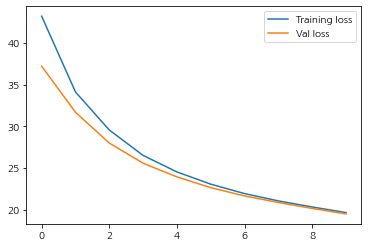

In [28]:
plt.plot(train_hist, label="Training loss")
plt.plot([i.tolist() for i in val_hist], label="Val loss")
plt.legend()


In [29]:
true_x,true_y = create_sequences(green_test,seqence_len,green_scaler)
with torch.no_grad():
    preds = []  # 예측값을 담을 리스트
    for _ in range(len(true_x)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(true_x[_], 0))
        preds.append(y_test_pred.tolist()[0])

In [54]:
pd.DataFrame(preds,index=green_test[-len(preds):].index,columns=green_test.columns[:len(preds[0])]).applymap(lambda x : 
                                                                                            round(x,0) if x >0 else 0)

,X3WAY1VOL,X3WAY2VOL,XABHUM,XCO2,XCO2SET,XCUR1VOL,XCUR2VOL,XCUR3VOL,XCUR4VOL,XDHUM,...,XVENT2RST,XVENTCONT,XVENTCONT2,XVENTRST,XVENTTEMP,XVENTTEMP2,XWATERTEMP,XWATERTEMP2,XWINDSP,farmId_gjkss
time,,,,,,,,,,,,,,,,,,,,,
2021-12-10 23:35:00,0.0,2.0,16.0,485.0,364.0,37.0,35.0,2.0,1.0,18.0,...,21.0,0.0,0.0,21.0,21.0,21.0,22.0,20.0,1.0,0.0
2021-12-10 23:35:00,1.0,0.0,13.0,528.0,392.0,18.0,19.0,0.0,0.0,15.0,...,19.0,0.0,0.0,19.0,19.0,19.0,31.0,30.0,1.0,0.0
2021-12-10 23:35:00,1.0,1.0,11.0,482.0,363.0,23.0,20.0,2.0,1.0,12.0,...,15.0,0.0,0.0,15.0,16.0,16.0,14.0,14.0,1.0,0.0
2021-12-10 23:35:00,0.0,0.0,10.0,526.0,392.0,2.0,1.0,0.0,10.0,12.0,...,11.0,0.0,0.0,12.0,12.0,12.0,4.0,2.0,0.0,0.0
2021-12-10 23:35:00,0.0,0.0,13.0,534.0,393.0,8.0,6.0,0.0,0.0,15.0,...,21.0,0.0,0.0,22.0,22.0,21.0,27.0,27.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 23:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 23:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
